In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from rdkit import Chem
from tqdm.autonotebook import tqdm

In [2]:
from rxitect.scorers.a2ascore import Predictor
from rxitect.scorers.rascore import mol2fcfp, load_rascore_model


a2a = Predictor(path="../models/RF_REG_CHEMBL251.pkg")
a1 = Predictor(path="../models/RF_REG_CHEMBL226.pkg")
herg = Predictor(path="../models/RF_REG_CHEMBL240.pkg")
ras = load_rascore_model("../models/rascore_26102022.ckpt")

 [*] Loading checkpoint from ../models/rascore_26102022.ckpt succeed!
Checkpoint restored!


In [3]:
drugex_base = pd.read_csv("../data/temp/drugex_rascore_100K_smiles.txt", header=None)
gfn_base = pd.read_csv("../data/temp/gfn_tb96_rascore_100K_smiles.txt", header=None)

In [4]:
drugex_fcfps = [mol2fcfp(m) for m in tqdm([Chem.MolFromSmiles(smi) for smi in tqdm(drugex_base[0], desc="Converting SMILES to RDKit Mols")], desc="Converting Mols to FCFPs")]
drugex_fcfps = torch.tensor(np.array(drugex_fcfps), dtype=torch.float, device="cpu")

Converting SMILES to RDKit Mols:   0%|          | 0/100000 [00:00<?, ?it/s]

Converting Mols to FCFPs:   0%|          | 0/100000 [00:00<?, ?it/s]

In [6]:
drugex_efps = Predictor.calc_fp(mols=[Chem.MolFromSmiles(smi) for smi in tqdm(drugex_base[0], desc="Converting SMILES to RDKit Mols")])

Converting SMILES to RDKit Mols:   0%|          | 0/100000 [00:00<?, ?it/s]

In [7]:
gfn_fcfps = [mol2fcfp(m) for m in tqdm([Chem.MolFromSmiles(smi) for smi in tqdm(gfn_base[0], desc="Converting SMILES to RDKit Mols")], desc="Converting Mols to FCFPs")]
gfn_fcfps = torch.tensor(np.array(gfn_fcfps), dtype=torch.float, device="cpu")

Converting SMILES to RDKit Mols:   0%|          | 0/100000 [00:00<?, ?it/s]

Converting Mols to FCFPs:   0%|          | 0/100000 [00:00<?, ?it/s]

In [8]:
gfn_efps = Predictor.calc_fp(mols=[Chem.MolFromSmiles(smi) for smi in tqdm(gfn_base[0], desc="Converting SMILES to RDKit Mols")])

Converting SMILES to RDKit Mols:   0%|          | 0/100000 [00:00<?, ?it/s]

In [9]:
drugex_a2a = a2a(drugex_efps)
drugex_a2a = torch.from_numpy(drugex_a2a.astype(np.float32))
drugex_a2a = (drugex_a2a / 8.8).clamp(0, 1)
drugex_a1 = a1(drugex_efps)
drugex_a1 = torch.from_numpy(drugex_a1.astype(np.float32))
drugex_a1 = (drugex_a1 / 8.6).clamp(0, 1)
drugex_herg = herg(drugex_efps)
drugex_herg = torch.from_numpy(drugex_herg.astype(np.float32))
drugex_herg = 1.0 -(drugex_herg / 7.4).clamp(0, 1)
drugex_rascores = ras(drugex_fcfps).detach().numpy()

<AxesSubplot: ylabel='Count'>

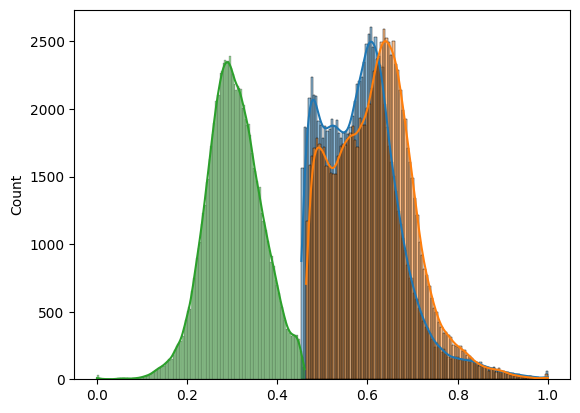

In [10]:
sns.histplot(drugex_a2a, stat="count", kde=True)
sns.histplot(drugex_a1, stat="count", kde=True)
sns.histplot(drugex_herg, stat="count", kde=True)

In [12]:
gfn_a2a = a2a(gfn_efps)
gfn_a2a = torch.from_numpy(gfn_a2a.astype(np.float32))
gfn_a2a = (gfn_a2a / 8.8).clamp(0, 1)
gfn_a1 = a1(gfn_efps)
gfn_a1 = torch.from_numpy(gfn_a1.astype(np.float32))
gfn_a1 = (gfn_a1 / 8.6).clamp(0, 1)
gfn_herg = herg(gfn_efps)
gfn_herg = torch.from_numpy(gfn_herg.astype(np.float32))
gfn_herg = 1.0 - (gfn_herg / 7.4).clamp(0, 1)
gfn_rascores = ras(gfn_fcfps).detach().numpy()

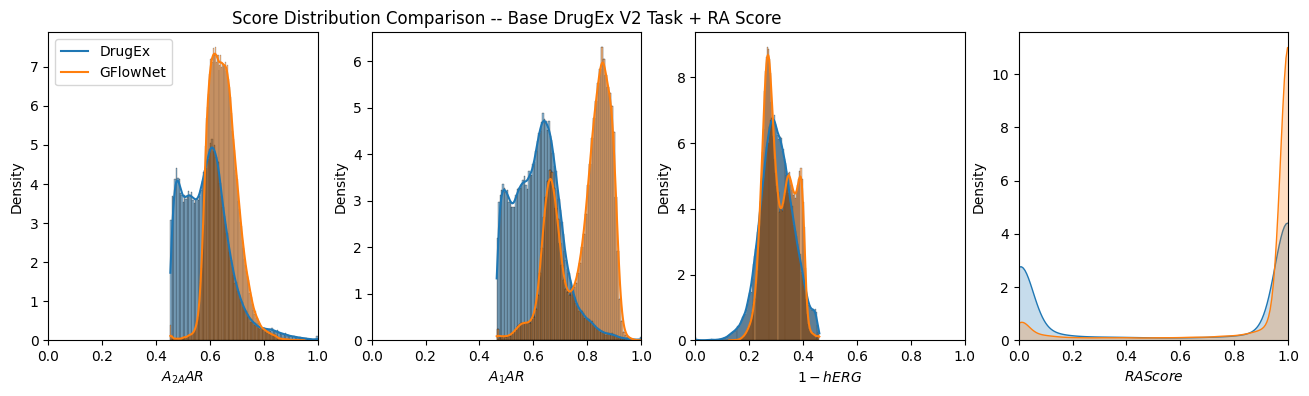

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
sns.histplot(drugex_a2a, stat="density", kde=True, ax=ax[0])
sns.histplot(gfn_a2a, stat="density", kde=True, ax=ax[0])
ax[0].legend(labels=["DrugEx", "GFlowNet"])
ax[0].set_xlim([0, 1])
ax[0].set_xlabel("$A_{2A}AR$")

sns.histplot(drugex_a1, stat="density", kde=True, ax=ax[1])
sns.histplot(gfn_a1, stat="density", kde=True, ax=ax[1])
ax[1].set_xlim([0, 1])
ax[1].set_xlabel("$A_{1}AR$")

sns.histplot(drugex_herg, stat="density", kde=True, ax=ax[2])
sns.histplot(gfn_herg, stat="density", kde=True, ax=ax[2])
ax[2].set_xlim([0, 1])
ax[2].set_xlabel("$1-hERG$")

sns.kdeplot(drugex_rascores.flatten(), ax=ax[3], fill=True)
sns.kdeplot(gfn_rascores.flatten(), ax=ax[3], fill=True)
# sns.histplot(drugex_rascores.flatten(), stat="count", kde=False, ax=ax[3])
# sns.histplot(gfn_rascores.flatten(), stat="count", kde=False, ax=ax[3])
ax[3].set_xlim([0, 1])
ax[3].set_xlabel("$RA Score$")

ax[1].set_title("Score Distribution Comparison -- Base DrugEx V2 Task + RA Score")
fig.savefig("../reports/score_dist_rascore_task.png")

<AxesSubplot: ylabel='Count'>

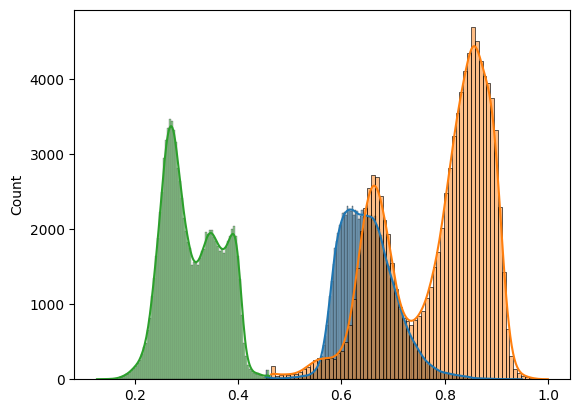

In [14]:
sns.histplot(gfn_a2a, stat="count", kde=True)
sns.histplot(gfn_a1, stat="count", kde=True)
sns.histplot(gfn_herg, stat="count", kde=True)

<AxesSubplot: ylabel='Count'>

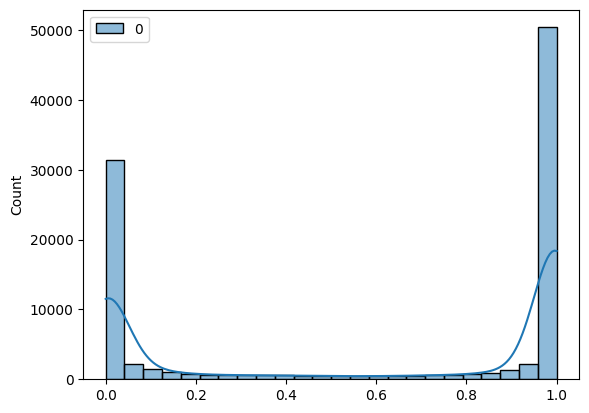

In [15]:
sns.histplot(drugex_rascores, stat="count", kde=True)

<AxesSubplot: ylabel='Count'>

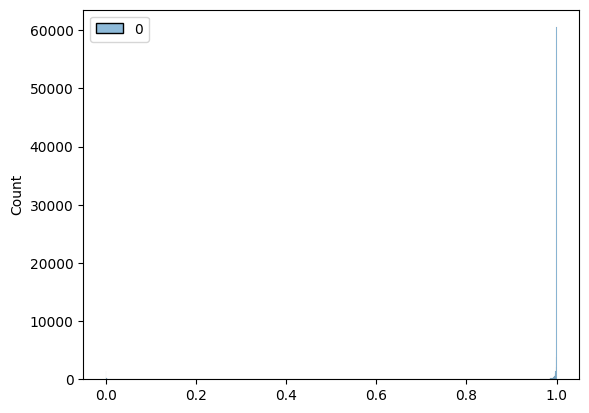

In [36]:
sns.histplot(gfn_rascores, stat="count", kde=False)

In [17]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [18]:
drugex_df = pd.DataFrame({"smiles":drugex_base[0], "A2A":drugex_a2a, "A1":drugex_a1, "hERG":drugex_herg, "RAScore":drugex_rascores.flatten()})
drugex_df.to_csv("../data/temp/drugex_rascore_100K_smiles_with_scores.csv", index=False)

In [19]:
gfn_df = pd.DataFrame({"smiles":gfn_base[0], "A2A":gfn_a2a, "A1":gfn_a1, "hERG":gfn_herg, "RAScore":gfn_rascores.flatten()})
gfn_df.to_csv("../data/temp/gfn_tb96_rascore_100K_smiles_with_scores.csv", index=False)

In [20]:
drugex_pf_idx = is_pareto_efficient(-drugex_df[["A2A", "A1", "hERG"]].to_numpy()[1:].astype(float), return_mask=False)
drugex_scores = drugex_df[["A2A", "A1", "hERG"]].to_numpy()[1:].astype(float)
drugex_pf = drugex_scores[drugex_pf_idx]

drugex_df3pf = pd.DataFrame({'x': drugex_pf[:,0], 'y': drugex_pf[:,1], 'z': drugex_pf[:,2]})

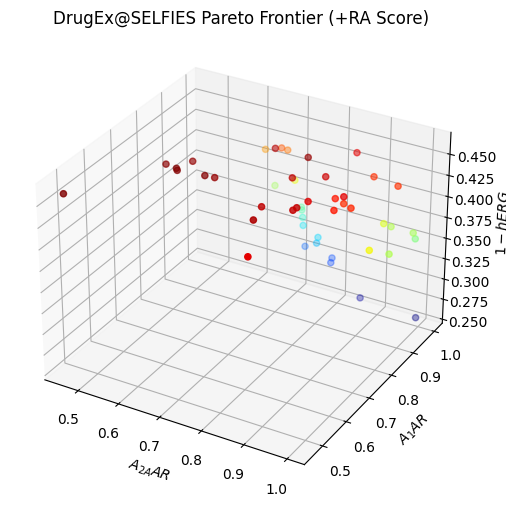

In [21]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(6, 6))
ax.remove()
ax=fig.add_subplot(projection='3d')
ax.scatter3D(drugex_df3pf.x, drugex_df3pf.y, drugex_df3pf.z, c=drugex_df3pf.z, cmap=cm.jet)
ax.set_xlabel("$A_{2A}AR$")
ax.set_ylabel("$A_{1}AR$")
ax.set_zlabel("$1-hERG$")
ax.set_title("DrugEx@SELFIES Pareto Frontier (+RA Score)")
fig.savefig("../reports/drugex_rascore_100K_pf.png")

In [63]:
gfn_pf_idx = is_pareto_efficient(-gfn_df[["A2A", "A1", "hERG"]].to_numpy()[1:].astype(float), return_mask=False)
gfn_scores = gfn_df[["A2A", "A1", "hERG"]].to_numpy()[1:].astype(float)
gfn_pf = gfn_scores[gfn_pf_idx]

gfn_df3pf = pd.DataFrame({'x': gfn_pf[:,0], 'y': gfn_pf[:,1], 'z': gfn_pf[:,2]})

Text(0.5, 0.92, 'GFN@TB Pareto Frontier (+RA Score)')

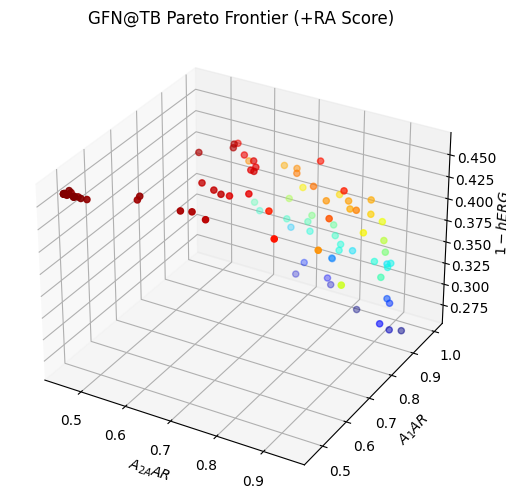

In [64]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(6, 6))
ax.remove()
ax=fig.add_subplot(projection='3d')
ax.scatter3D(gfn_df3pf.x, gfn_df3pf.y, gfn_df3pf.z, c=gfn_df3pf.z, cmap=cm.jet)
ax.set_xlabel("$A_{2A}AR$")
ax.set_ylabel("$A_{1}AR$")
ax.set_zlabel("$1-hERG$")
ax.set_title("GFN@TB Pareto Frontier (+RA Score)")
fig.savefig("../reports/gfn_tb96_rascore_100K_pf.png")

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    fig = None
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    if fig:
        cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
        cbar.ax.set_ylabel('Density')

    return ax

# Pairplot stuff goes here

In [41]:
from rdkit.Chem import QED
from rdkit.Chem.Descriptors import MolWt
from rxitect.scorers.sascore import calculateScore

In [42]:
mols = [Chem.MolFromSmiles(smi) for smi in drugex_base[0]]

In [43]:
sas = [calculateScore(m) for m in mols]
sa_scores = (10 - np.array(sas)) / 9  # transform to [0-1]

In [44]:
qeds = [QED.qed(m) for m in mols]
mws = torch.from_numpy(np.array([MolWt(m) for m in mols]))
sc_mws = (mws / 1000).clip(0, 1)

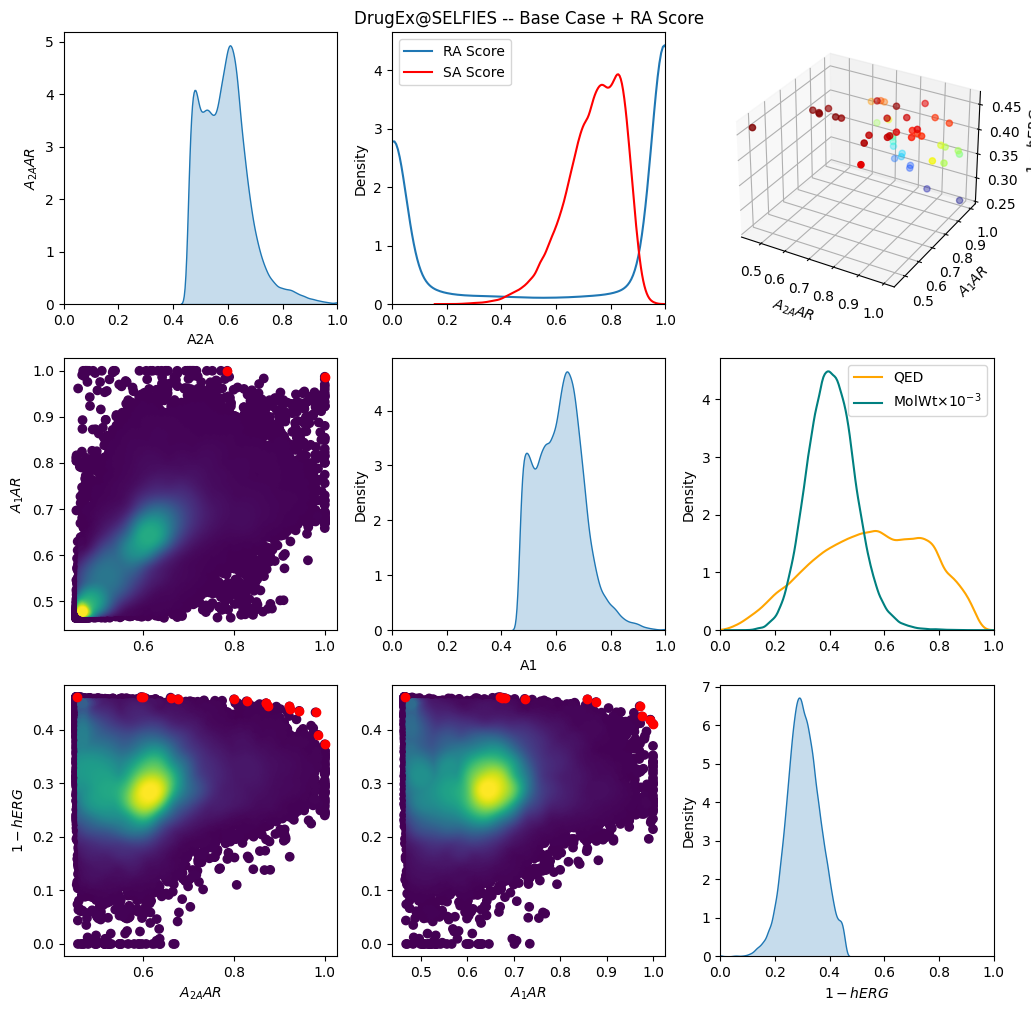

In [45]:
df = drugex_df.copy()
dfx = df[["A2A", "hERG"]]# .to_numpy()[1:].astype(float)
a2a_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A2A", "A1"]]# .to_numpy()[1:].astype(float)
a2a_a1_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A1", "hERG"]]# .to_numpy()[1:].astype(float)
a1_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
plt.close()
pf_col = "red"
fig, ax = plt.subplots(3, 3, figsize=(12,12))
# ax[2, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel("$A_{2A}AR$")
ax[1, 0].set_ylabel("$A_{1}AR$")
ax[2, 0].set_ylabel("$1-hERG$")
ax[2, 0].set_xlabel("$A_{2A}AR$")
ax[2, 1].set_xlabel("$A_{1}AR$")
ax[2, 2].set_xlabel("$1-hERG$")
# ax[2, 1].set_ylim([0, 1])
ax[2, 2].set_xlim([0, 1])
ax[1, 1].set_xlim([0, 1])
ax[0, 0].set_xlim([0, 1])
density_scatter(df["A2A"], df["hERG"], ax=ax[2, 0])
sns.kdeplot(drugex_rascores, ax=ax[0, 1], color="green")
sns.kdeplot(sa_scores, ax=ax[0, 1], color="red")
ax[0, 1].set_xlim([0, 1])
ax[0, 1].legend(labels=["RA Score", "SA Score"])
sns.kdeplot(qeds, ax=ax[1, 2], color="orange")
sns.kdeplot(sc_mws, ax=ax[1, 2], color="teal")
ax[1, 2].set_xlim([0, 1])
ax[1, 2].legend(labels=["QED", "MolWt$\\times10^{-3}$"])
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[1, 1], color="green")
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[2, 2], color="green")
ax[2, 0].scatter(a2a_herg_pf[:, 0], a2a_herg_pf[:, 1], color=pf_col)
density_scatter(df["A2A"], df["A1"], ax=ax[1, 0])
ax[1, 0].scatter(a2a_a1_pf[:, 0], a2a_a1_pf[:, 1], color=pf_col)
density_scatter(df["A1"], df["hERG"], ax=ax[2, 1])
ax[2, 1].scatter(a1_herg_pf[:, 0], a1_herg_pf[:, 1], color=pf_col)
sns.kdeplot(df["A2A"], ax=ax[0, 0], fill=True)
sns.kdeplot(df["A1"], ax=ax[1, 1], fill=True)
sns.kdeplot((df["hERG"]), ax=ax[2, 2], fill=True)
# ax[0, 1].axis('off')
# ax[0, 2].axis('off')
ax[0, 2].remove()
ax[0, 2]=fig.add_subplot(3,3,3,projection='3d')
ax[0, 2].scatter3D(drugex_df3pf.x, drugex_df3pf.y, drugex_df3pf.z, c=drugex_df3pf.z, cmap=cm.jet)
ax[0, 2].set_xlabel("$A_{2A}AR$")
ax[0, 2].set_ylabel("$A_{1}AR$")
ax[0, 2].set_zlabel("$1-hERG$")
# ax[1, 2].axis('off')

ax[0, 1].set_title("DrugEx@SELFIES -- Base Case + RA Score")
fig.savefig("../reports/drugex_rascore_100K_pairplot.png")

In [46]:
from rdkit.Chem import QED
from rdkit.Chem.Descriptors import MolWt
from rxitect.scorers.sascore import calculateScore

In [47]:
mols = [Chem.MolFromSmiles(smi) for smi in gfn_base[0]]

In [48]:
sas = [calculateScore(m) for m in mols]
sa_scores = (10 - np.array(sas)) / 9  # transform to [0-1]

In [49]:
qeds = [QED.qed(m) for m in mols]
mws = torch.from_numpy(np.array([MolWt(m) for m in mols]))
sc_mws = (mws / 1000).clip(0, 1)

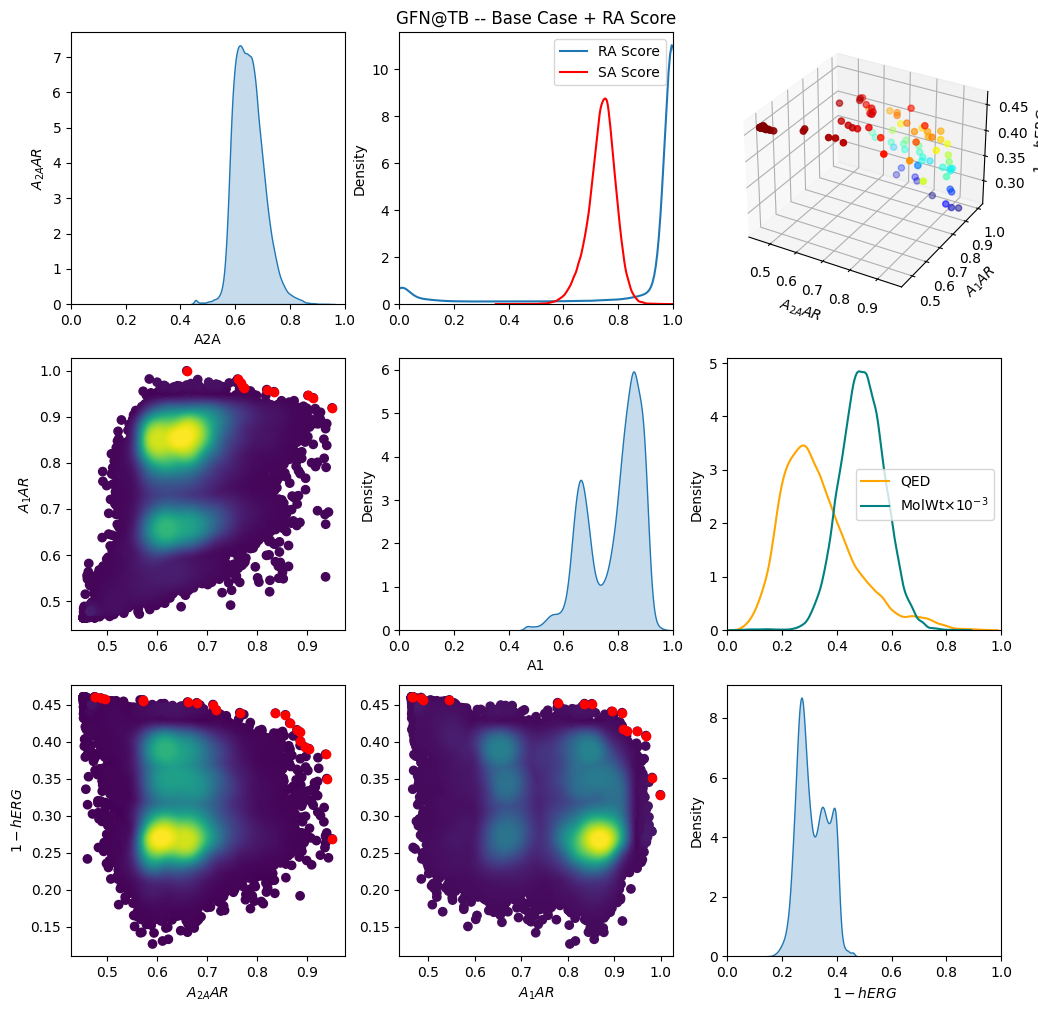

In [50]:
df = gfn_df.copy()
dfx = df[["A2A", "hERG"]]# .to_numpy()[1:].astype(float)
a2a_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A2A", "A1"]]# .to_numpy()[1:].astype(float)
a2a_a1_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
dfx = df[["A1", "hERG"]]# .to_numpy()[1:].astype(float)
a1_herg_pf = dfx.to_numpy()[is_pareto_efficient(-dfx.to_numpy().astype(float), return_mask=False)]
plt.close()
pf_col = "red"
fig, ax = plt.subplots(3, 3, figsize=(12,12))
# ax[2, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel("$A_{2A}AR$")
ax[1, 0].set_ylabel("$A_{1}AR$")
ax[2, 0].set_ylabel("$1-hERG$")
ax[2, 0].set_xlabel("$A_{2A}AR$")
ax[2, 1].set_xlabel("$A_{1}AR$")
ax[2, 2].set_xlabel("$1-hERG$")
# ax[2, 1].set_ylim([0, 1])
ax[2, 2].set_xlim([0, 1])
ax[1, 1].set_xlim([0, 1])
ax[0, 0].set_xlim([0, 1])
density_scatter(df["A2A"], df["hERG"], ax=ax[2, 0])
sns.kdeplot(gfn_rascores, ax=ax[0, 1], color="green")
sns.kdeplot(sa_scores, ax=ax[0, 1], color="red")
ax[0, 1].set_xlim([0, 1])
ax[0, 1].legend(labels=["RA Score", "SA Score"])
sns.kdeplot(qeds, ax=ax[1, 2], color="orange")
sns.kdeplot(sc_mws, ax=ax[1, 2], color="teal")
ax[1, 2].set_xlim([0, 1])
ax[1, 2].legend(labels=["QED", "MolWt$\\times10^{-3}$"])
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[1, 1], color="green")
# sns.kdeplot(ras_scores.reshape(-1).detach().cpu(), ax=ax[2, 2], color="green")
ax[2, 0].scatter(a2a_herg_pf[:, 0], a2a_herg_pf[:, 1], color=pf_col)
density_scatter(df["A2A"], df["A1"], ax=ax[1, 0])
ax[1, 0].scatter(a2a_a1_pf[:, 0], a2a_a1_pf[:, 1], color=pf_col)
density_scatter(df["A1"], df["hERG"], ax=ax[2, 1])
ax[2, 1].scatter(a1_herg_pf[:, 0], a1_herg_pf[:, 1], color=pf_col)
sns.kdeplot(df["A2A"], ax=ax[0, 0], fill=True)
sns.kdeplot(df["A1"], ax=ax[1, 1], fill=True)
sns.kdeplot((df["hERG"]), ax=ax[2, 2], fill=True)
# ax[0, 1].axis('off')
# ax[0, 2].axis('off')
ax[0, 2].remove()
ax[0, 2]=fig.add_subplot(3,3,3,projection='3d')
ax[0, 2].scatter3D(gfn_df3pf.x, gfn_df3pf.y, gfn_df3pf.z, c=gfn_df3pf.z, cmap=cm.jet)
ax[0, 2].set_xlabel("$A_{2A}AR$")
ax[0, 2].set_ylabel("$A_{1}AR$")
ax[0, 2].set_zlabel("$1-hERG$")
# ax[1, 2].axis('off')

ax[0, 1].set_title("GFN@TB -- Base Case + RA Score")
fig.savefig("../reports/gfn_tb96_rascore_100K_pairplot.png")

<AxesSubplot: xlabel='RAScore', ylabel='Count'>

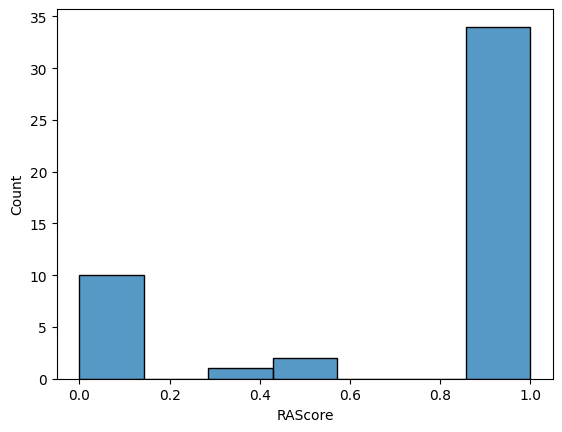

In [82]:
sns.histplot(drugex_df[1:].iloc[drugex_pf_idx].RAScore)

<AxesSubplot: xlabel='RAScore', ylabel='Count'>

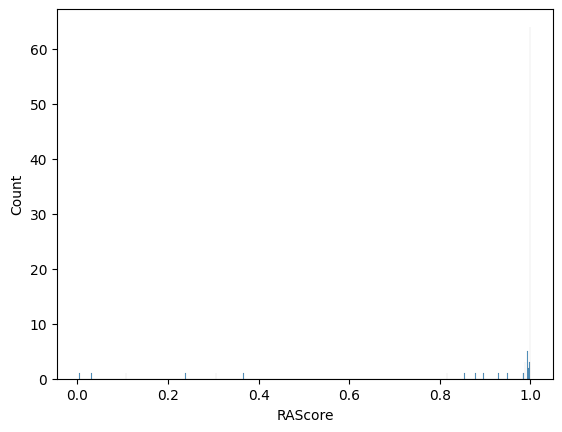

In [84]:
sns.histplot(gfn_df[1:].iloc[gfn_pf_idx].RAScore, kde=False)

In [68]:
gfn_df.iloc[gfn_pf_idx]

,smiles,A2A,A1,hERG,RAScore
1206,N#Cc1cc(S(N)(=O)=O)c(-c2ccc[nH+]c2)c(-c2nccc(N...,0.708917,0.809240,0.376489,0.861450
1406,Nc1cccc(-c2nc(F)c(-c3cncnc3)c(-c3cccnc3)c2-c2c...,0.647578,0.874805,0.281357,0.999985
2721,NS(=O)(=O)c1ccncc1C1CCOCC1c1ncc(-c2ccccc2-c2nc...,0.665372,0.646253,0.275217,0.999409
4483,[NH3+]Cc1cnccc1-c1ccnc(C(=O)O)c1-c1nccc(-c2cc[...,0.609467,0.886154,0.377426,0.663677
5347,NC(=O)c1nc(-n2cnc3cncnc32)c(NC=O)c(-c2ccn(NC=O...,0.623590,0.845582,0.408235,0.993987
...,...,...,...,...,...
94865,O=CNCc1cncnc1-c1c(P(=O)(O)O)ccc(-c2cnc(C=O)nc2...,0.617953,0.890130,0.369646,0.831662
96610,CC(C)(C)c1csc(-c2cc(-c3ncnc4[nH]cnc34)c(P(=O)(...,0.694993,0.779378,0.253449,0.920612
96939,N#Cc1ccccc1-c1ccc(Cl)c(-c2ncncc2-c2cccnc2)c1NC...,0.631675,0.835861,0.288822,0.959810
97946,NS(=O)(=O)c1c(-c2nc(-c3nccs3)cs2)cc([N+](=O)[O...,0.728832,0.657496,0.355283,0.999986


In [85]:
gfn_df[1:].iloc[gfn_pf_idx].to_csv("../reports/gfn_rascore_pareto_front.csv", index=False)  # Note: I somehow forgot to remove the [1:] here... but oh well it's already everywhere :')

In [86]:
drugex_df[1:].iloc[drugex_pf_idx].to_csv("../reports/drugex_rascore_pareto_front.csv", index=False)  # Note: I somehow forgot to remove the [1:] here... but oh well it's already everywhere :')

In [105]:
gfn_df[1:].iloc[gfn_pf_idx].query("RAScore > 0.99").sample(16).to_csv("../data/temp/gfn_rascore_synthesizable_samples.csv", index=False)

In [106]:
gfn_pf_ra_samples = pd.read_csv("../data/temp/gfn_rascore_synthesizable_samples.csv")

In [107]:
gfn_pf_ra_samples

,smiles,A2A,A1,hERG,RAScore
0,Nc1cc(P(=O)(O)O)nc(C(=O)[O-])c1-c1ccc(-c2ncncc...,0.854040,0.869454,0.408387,0.996528
1,CN(C)C(=O)NNC(=O)c1nc(N)c(C#N)c(C#N)n1,0.836380,0.585636,0.438959,0.999986
2,N#Cc1cc(-n2cnc3cncnc32)c(-c2c(N)nc(N)nc2C#N)c(...,0.921276,0.884421,0.378759,0.999983
3,Cc1nc(C(=O)NS(N)(=O)=O)nc(-n2cccn2)c1-c1cnn(-n...,0.600231,0.927811,0.414609,0.999212
4,N#Cc1c(N)nc(-c2nc(S(N)(=O)=O)cs2)nc1F,0.664672,0.665997,0.449140,0.993890
5,Nc1cncnc1-c1cc(-c2cccnc2)nc(I)c1-c1cc[nH]c(=O)n1,0.714709,0.966058,0.351174,0.998946
6,N#Cc1csc(-c2nc(C#N)nc(N)c2N)n1,0.711817,0.548192,0.450471,0.999513
7,Nc1ccnc(-c2ccn[nH]2)c1-c1cnc(F)nc1N,0.765289,0.916989,0.439479,0.998805
8,Nc1ccccc1-c1c(-c2cncnc2)cccc1-c1ncc(C[NH3+])cn1,0.915878,0.917391,0.338915,0.999932
9,N#Cc1nc(F)cc(-c2c(-c3cccnc3)cc(I)nc2-c2ccccc2)c1F,0.756572,0.974974,0.287930,0.999924


In [108]:
drugex_df[1:].iloc[drugex_pf_idx].query("RAScore > 0.99").sample(16).to_csv("../data/temp/drugex_rascore_synthesizable_samples.csv", index=False)

In [109]:
pd.read_csv("../data/temp/drugex_rascore_synthesizable_samples.csv")

,smiles,A2A,A1,hERG,RAScore
0,CNC(=O)C1=CC(CSC2=NC(N)=C(C#N)C(C3=CC=C(OCCO)C...,0.711071,1.000000,0.339600,0.999960
1,NC1=NC2=C(Cl)N=CN=C2C3=NC(C4=CC=CO4)=NN13,0.918151,0.930818,0.432703,0.998924
2,CN1C=C2C(N=C(N)N3N=C(C4=CC=CO4)N=C23)=N1,0.943858,0.781701,0.434814,0.999920
3,C#CCN1C(C2=CC=CO2)=NC3=C(N)N=CN=C31,0.902289,0.790868,0.438008,0.999667
4,CCN1N=CC2=C1N=C(N)N3N=C(C4=CC=CO4)N=C23,0.923000,0.747270,0.437622,0.999884
5,NC1=NC=C(C2=CC=C(O)C=C2)C(C3=CC=CC=C3)=N1,0.951467,0.951456,0.373167,1.000000
6,NC1=NC=NC2=C1N=C(C3=CC=CO3)N2CCO,0.856789,0.832428,0.447450,0.997942
7,N#CC1=C(N)N=C(SCC2=CSC(N)=N2)C(C#N)=C1C3=CC=C(...,0.761234,0.979183,0.326879,0.999919
8,CCNC(=O)C1OC(N2C=NC3=C(NCC)N=C(C#CC(O)C4=CC=C(...,0.700449,0.982488,0.387774,0.995346
9,NC1=NC(N2C=CC=N2)=NC(N3N=CC=N3)=C1Br,0.870254,0.670968,0.448940,0.999878
